In [16]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from livetime import query_pot_interval, get_livetime_interval
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator, HourLocator
import matplotlib.dates as mdates
from tqdm import tqdm
from zoneinfo import ZoneInfo
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg


plt.style.use('style.mplstyle')

## Settings
Nothing special, just change the plot start and end times, along with the "delta" (interval length) that will be used for the bin size.

In [17]:
# Plot start/end and the interval delta
# Run 1:
#plot_start = datetime.strptime('2024-12-09 00:00:00', '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
#plot_end = datetime.strptime('2025-07-12 00:00:00', '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
#delta = timedelta(hours=4)

# Run 2:
plot_start = datetime.strptime('2025-10-16 00:00:00', '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
plot_end = datetime.strptime('2026-02-11 00:00:00', '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
delta = timedelta(hours=4)

## Extract the Livetime Info
This step calculates the livetime (POT and spills) per interval of time according to the settings above. This relies on `starts.txt` and `ends.txt`, which contain the timestamps copied directly from the DAQ Runs spreadsheet (natively in UTC).

In [8]:
# Read the run start times from `starts.txt`
with open('starts.txt', 'r') as f:
    lines = f.readlines()
    starts = [datetime.strptime(line.strip(), '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc) for line in lines]

# Read the run end times from `ends.txt`
with open('ends.txt', 'r') as f:
    lines = f.readlines()
    ends = [datetime.strptime(line.strip(), '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc) if line != 'now\n' else datetime.now(timezone.utc) for line in lines]


# Get the livetime data in each 'delta' interval
livetime_data = {'start': [], 'end': [], 'livetime': [],
                 'livetime_fraction': [], 'delivered_spills': [],
                 'collected_spills': [], 'delivered_pot': [],
                 'collected_pot': []}

# Create ranges for the intervals
range_starts = []
range_ends = []
start = plot_start
while start < plot_end:
    end = start + delta
    range_starts.append(start)
    range_ends.append(end)
    start += delta

# For each interval, get the livetime data (delivered and collected spills, pot)
for start, end in tqdm(zip(range_starts, range_ends), total=len(range_starts), desc='Processing intervals'):
    livetime = get_livetime_interval(start, end, starts, ends)
    livetime_data['start'].append(start)
    livetime_data['end'].append(end)
    livetime_data['livetime'].append(livetime[0])
    livetime_data['livetime_fraction'].append(livetime[1])
    livetime_data['delivered_spills'].append(livetime[2])
    livetime_data['collected_spills'].append(livetime[3])
    livetime_data['delivered_pot'].append(livetime[4])
    livetime_data['collected_pot'].append(livetime[5])

# Create a DataFrame with the livetime data
livetime_df = pd.DataFrame(livetime_data)
display(livetime_df.head(20))
livetime_df.to_csv("sbnd_livetime_temp.csv", index="false")

Processing intervals: 100%|██████████| 708/708 [29:34<00:00,  2.51s/it]


,start,end,livetime,livetime_fraction,delivered_spills,collected_spills,delivered_pot,collected_pot
0,2025-10-16 00:00:00+00:00,2025-10-16 04:00:00+00:00,14400.0,1.000000,43152,43152,40.776265,40.776265
1,2025-10-16 04:00:00+00:00,2025-10-16 08:00:00+00:00,11710.0,0.813194,43150,35067,45.273351,35.554218
2,2025-10-16 08:00:00+00:00,2025-10-16 12:00:00+00:00,14400.0,1.000000,43143,43143,42.194325,42.194325
3,2025-10-16 12:00:00+00:00,2025-10-16 16:00:00+00:00,13272.0,0.921667,22773,22660,42.836954,42.850795
4,2025-10-16 16:00:00+00:00,2025-10-16 20:00:00+00:00,11802.0,0.819583,1439,1179,178.851080,153.944324
5,2025-10-16 20:00:00+00:00,2025-10-17 00:00:00+00:00,13810.0,0.959028,40647,37697,84674.966402,77369.865215
6,2025-10-17 00:00:00+00:00,2025-10-17 04:00:00+00:00,13213.0,0.917569,72004,66069,172107.386717,157292.173527
7,2025-10-17 04:00:00+00:00,2025-10-17 08:00:00+00:00,14400.0,1.000000,71984,71984,183482.281914,183482.281914
8,2025-10-17 08:00:00+00:00,2025-10-17 12:00:00+00:00,13196.0,0.916389,71997,65977,184159.838836,168715.694871
9,2025-10-17 12:00:00+00:00,2025-10-17 16:00:00+00:00,13359.0,0.927708,71975,66785,172673.450694,164839.146699


## DAQ Uptime
This plots the DAQ uptime, or fraction of time that the DAQ was being used. This does not include "expert" runs where the run was not logged in the spreadsheet (this appears like downtime). Please note that this may cause lower than "actual" uptimes!

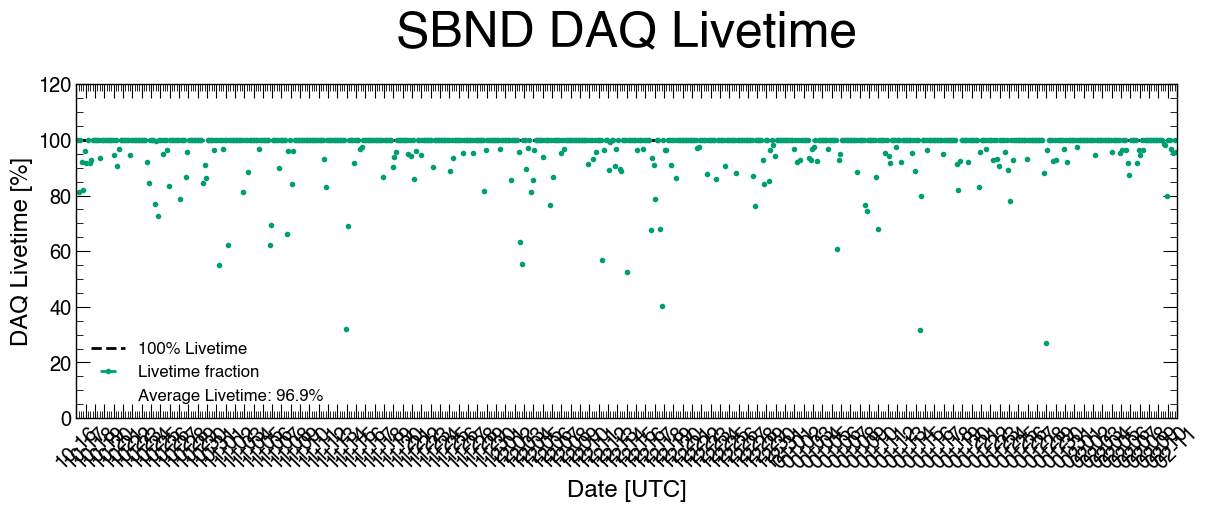

In [9]:
livetime_df = pd.read_csv('/Users/odalager/Desktop/SBND/RunCo/pot/sbnd_livetime_temp.csv')

# convert to datetime
livetime_df['start'] = pd.to_datetime(livetime_df['start'])
livetime_df['end'] = pd.to_datetime(livetime_df['end'])

# Figure creation
figure = plt.figure(figsize=(12, 5))
ax = figure.add_subplot()

# Plot the livetime fraction
diff = livetime_df['end'] - livetime_df['start']
centers = livetime_df['start'] + diff / 2
ax.errorbar(centers,
            100*livetime_df['livetime_fraction'],
            xerr=diff / 2,
            fmt='o',
            label='Livetime fraction',
            markersize=3)
ax.set_xlabel('Date [UTC]')
ax.set_ylabel('DAQ Livetime [%]')

# Only show the x-axis label every day and rotate the labels
# Set major ticks to be every day
ax.xaxis.set_major_locator(DayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='center')

# Set minor ticks to be every 6 hours
ax.xaxis.set_minor_locator(HourLocator(interval=6))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, ha='center')

# Set axis limits
ax.set_xlim(plot_start, plot_end)
ax.set_ylim(0, 120)
ax.axhline(100, color='black', linestyle='--', label='100% Livetime')

# Add a legend, but add statistics showing the average livetime fraction
h, l = ax.get_legend_handles_labels()
avg_livetime = np.mean(livetime_df['livetime_fraction'])

# Add the average livetime to the legend, but with a "blank" handle
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Average Livetime: {avg_livetime:.1%}')
ax.legend(h, l)

_ = ax.set_title('SBND DAQ Livetime')

## POT Collection Efficiency
This plots the POT collection efficiency, which represents the fraction of POT delivered by AD to the BNB that SBND was online and capable of taking physics-quality data for.

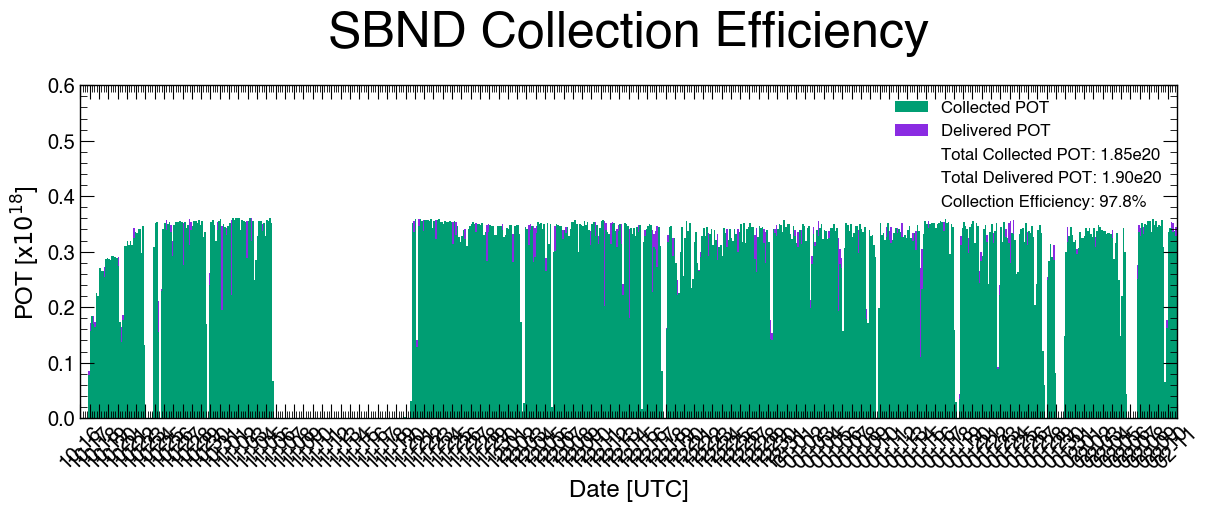

In [10]:
livetime_df = pd.read_csv('/Users/odalager/Desktop/SBND/RunCo/pot/sbnd_livetime_temp.csv')

# convert to datetime
livetime_df['start'] = pd.to_datetime(livetime_df['start'])
livetime_df['end'] = pd.to_datetime(livetime_df['end'])
diff = livetime_df['end'] - livetime_df['start']

# Figure creation for POT delivered and collected
figure = plt.figure(figsize=(12, 5))
ax = figure.add_subplot()

# Stacked bar plot of the total POT delivered and collected.
ax.bar(centers, livetime_df['collected_pot']/1e6, width=diff, label='Collected POT', alpha=1, zorder=1, color='C0')
ax.bar(centers, livetime_df['delivered_pot']/1e6, width=diff, label='Delivered POT', alpha=1, zorder=0, color='blueviolet')
ax.set_xlabel('Date [UTC]')
ax.set_ylabel('POT [x$10^{18}$]')

# Only show the x-axis label every day and rotate the labels
# Set major ticks to be every day
ax.xaxis.set_major_locator(DayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='center')

# Set minor ticks to be every 6 hours
ax.xaxis.set_minor_locator(HourLocator(interval=6))
plt.setp(ax.xaxis.get_minorticklabels(), rotation=45, ha='center')

# Set axis limits
ax.set_xlim(plot_start, plot_end)
ax.set_ylim(0, 0.60)

# Add a legend, but add statistics showing the total delivered POT,
# collected POT, and the collection efficiency
h, l = ax.get_legend_handles_labels()
total_delivered_pot = np.sum(livetime_df['delivered_pot'])
total_collected_pot = np.sum(livetime_df['collected_pot'])
collection_efficiency = total_collected_pot / total_delivered_pot

# Add the average livetime to the legend, but with a "blank" handle
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Total Collected POT: {total_collected_pot*1e12:.2e}'.replace('+', ''))
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Total Delivered POT: {total_delivered_pot*1e12:.2e}'.replace('+', ''))
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Collection Efficiency: {collection_efficiency:.1%}')
ax.legend(h, l)

# Title
_ = ax.set_title('SBND Collection Efficiency')

# Run 2 Cumulative

Hit  15 at  2026-01-20 12:00:00+00:00  +  1.5187047648285208 hours 
	 14.986879139673329 15.021437167357275
Total Delivered POT: 189608666.78208125


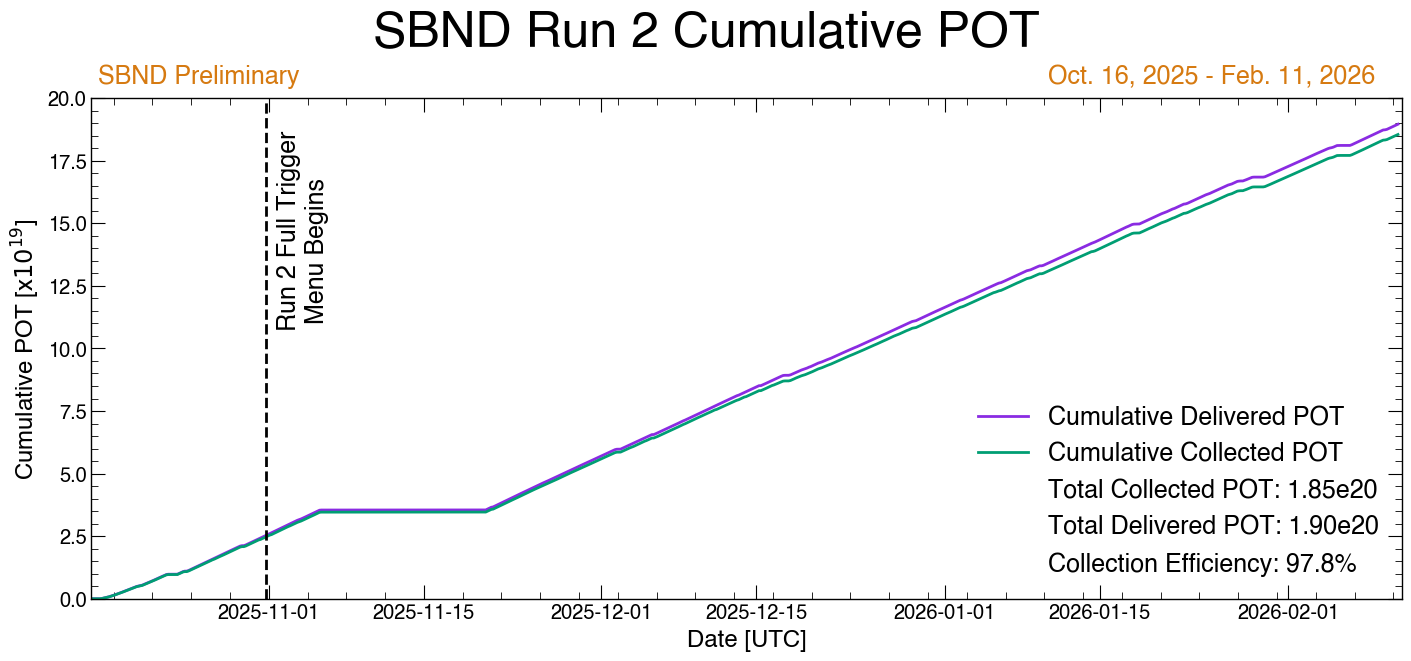

In [13]:
#Run 2 only
livetime_df = pd.read_csv('/Users/odalager/Desktop/SBND/RunCo/pot/sbnd_livetime_temp.csv')

livetime_df['start'] = pd.to_datetime(livetime_df['start'])
livetime_df['end'] = pd.to_datetime(livetime_df['end'])

figure = plt.figure(figsize=(14, 6.5))
ax = figure.add_subplot()

# Center points for the x-axis
diff = livetime_df['end'] - livetime_df['start']
centers = livetime_df['start'] + diff / 2

# Print the times of hitting key values
pot_of_interest = 15
collected_pot_sofar = 0 #this is e19
for i, row in livetime_df.iterrows():
    if(collected_pot_sofar < pot_of_interest):
        collected_pot_sofar = collected_pot_sofar + row['collected_pot']/1e7
        if(collected_pot_sofar > pot_of_interest): print("Hit ", pot_of_interest, "at ", row['start'], " + ", (pot_of_interest-(collected_pot_sofar-row['collected_pot']/1e7))/(row['collected_pot']/1e7)*4, "hours \n\t", collected_pot_sofar-row['collected_pot']/1e7, collected_pot_sofar)



# Annotations
annotes = {'Run 2 Full Trigger \n Menu Begins': datetime(2025, 10, 31, 17, 19, 56, tzinfo=timezone.utc),}


# Each time point is a cumulative sum of the delivered / collected POT
ax.plot(centers, np.cumsum(livetime_df['delivered_pot'])/1e7, label='Cumulative Delivered POT', color='blueviolet')
ax.plot(centers, np.cumsum(livetime_df['collected_pot'])/1e7, label='Cumulative Collected POT', color='C0')
#ax.plot(centers, np.cumsum(0.955*livetime_df['collected_pot'])/1e7, label='Cumulative Collected POT minus 4.5%', color='orange')


ax.set_xlabel('Date [UTC]')
ax.set_ylabel('Cumulative POT [x$10^{19}$]')
ax.set_xlim(datetime(2025, 10, 16, 0, 0, 0, tzinfo=timezone.utc),
            datetime(2026, 2, 11, 0, 0, 0, tzinfo=ZoneInfo('America/Chicago')))
ax.set_ylim(0, 20)

# Add a legend, but add statistics showing the total delivered POT,
# collected POT, and the collection efficiency
mask = ((livetime_df['start'] >= datetime(2025, 10, 16, 0, 0, 0, tzinfo=timezone.utc))
        & (livetime_df['end'] <= datetime(2026, 2, 11, 0, 0, 0, tzinfo=ZoneInfo('America/Chicago'))))


h, l = ax.get_legend_handles_labels()
total_delivered_pot = np.sum(livetime_df['delivered_pot'][mask])
print(f'Total Delivered POT: {total_delivered_pot}')
total_collected_pot = np.sum(livetime_df['collected_pot'][mask])
collection_efficiency = total_collected_pot / total_delivered_pot

# Add the average livetime to the legend, but with a "blank" handle
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Total Collected POT: {total_collected_pot*1e12:.2e}'.replace('+', ''))
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Total Delivered POT: {total_delivered_pot*1e12:.2e}'.replace('+', ''))
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Collection Efficiency: {collection_efficiency:.1%}')
ax.legend(h, l, loc='lower right', fontsize=18)



date_padding = timedelta(days=1)
for label, date in annotes.items():
    ax.axvline(date, color='black', linestyle='--', lw=2)
    #ax.text(date+date_padding, 37.5-1.0, label, rotation=90, ha='left', va='top', fontsize=18,)
    ax.text(date+date_padding, 0.95, label, rotation=90, ha='left', va='top', fontsize=18,transform=ax.get_xaxis_transform())


vadj, hadj = 0.02, -0.02
label = 'SBND Preliminary'

yrange = ax.get_ylim()
usey = yrange[1] + 0.01*(yrange[1] - yrange[0]) + vadj*(yrange[1] - yrange[0])
xrange = ax.get_xlim()
usex = xrange[0] + 0.025*(xrange[1] - xrange[0]) + hadj*(xrange[1] - xrange[0])
ax.text(x=usex, y=usey, s=label, fontsize=18, color='#d67a11')

# Opposite the previous label, place the dates
date_label = 'Oct. 16, 2025 - Feb. 11, 2026'
#date_label = 'Dec. 10, 2024 - Jan. 14, 2026'
ax.text(x=xrange[1] + hadj*(xrange[1] - xrange[0]),
        y=usey, s=date_label, fontsize=18, color='#d67a11', ha='right')

logo = mpimg.imread('/Users/odalager/Desktop/SBND/RunCo/pot/sbnd_logo.jpeg')
im = OffsetImage(logo, zoom=0.5, alpha=0.2)

# create an AnnotationBbox at axes fraction (x=0.5,y=0.5) = the center
# you can move it to e.g. (0.9,0.1) for bottom-right, etc.
ab = AnnotationBbox(
    im,
    #(0.12, 0.7),                # x,y in axes fraction
    (0.5, 0.5),
    xycoords='axes fraction',
    frameon=False,             # no border
    pad=0                      # no extra padding
)
#ax.add_artist(ab)

figure.suptitle('SBND Run 2 Cumulative POT')
figure.savefig('/Users/odalager/Desktop/SBND/RunCo/pot/livetime_pot_cumulative_run2_temp.png', dpi=1000, bbox_inches='tight')
figure.savefig('/Users/odalager/Desktop/SBND/RunCo/pot/livetime_pot_cumulative_run2_temp.pdf', dpi=1000, bbox_inches='tight')

# Run 1 + Run 2 Cumulative

Total Delivered POT: 557908267.5580425


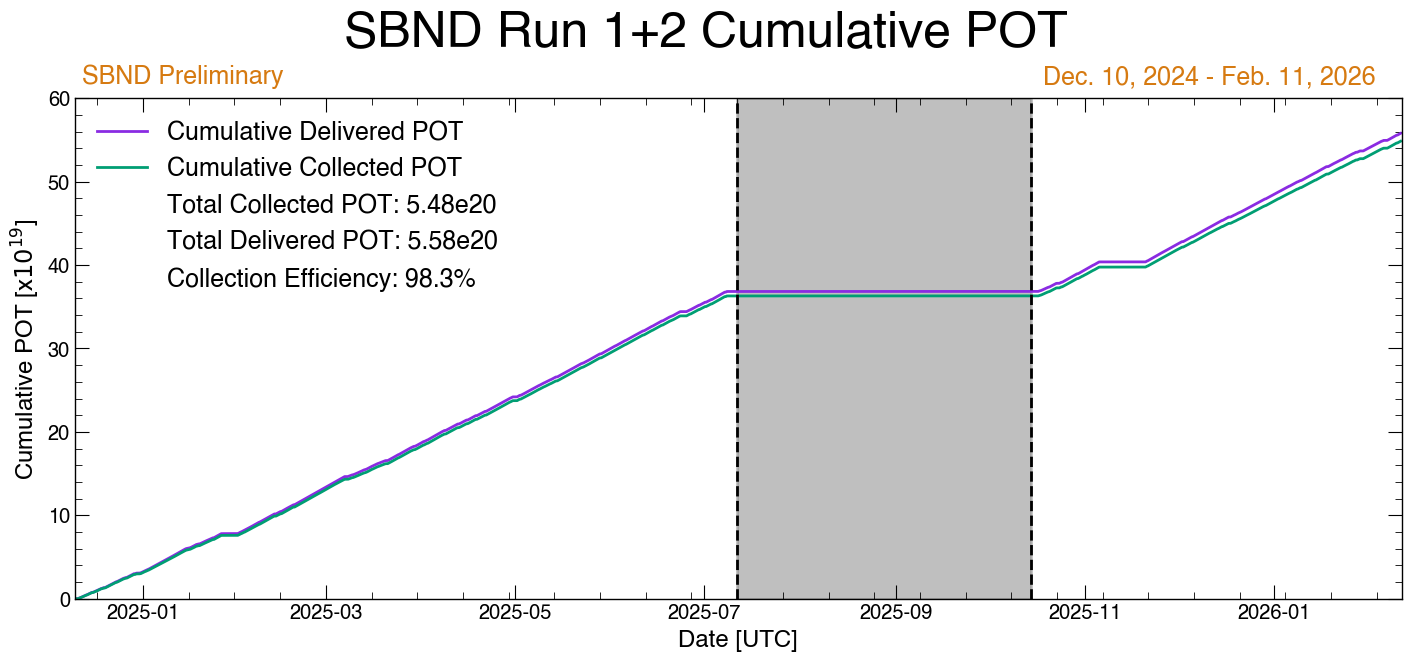

In [15]:
#Run 1 file
livetime_run1_df = pd.read_csv('/Users/odalager/Desktop/SBND/RunCo/pot/sbnd_livetime_run1.csv')
#Run 2 file
livetime_run2_df = pd.read_csv('/Users/odalager/Desktop/SBND/RunCo/pot/sbnd_livetime_temp.csv')
#Combine them
livetime_df = pd.concat([livetime_run1_df, livetime_run2_df], ignore_index=True)

livetime_df['start'] = pd.to_datetime(livetime_df['start'])
livetime_df['end'] = pd.to_datetime(livetime_df['end'])

figure = plt.figure(figsize=(14, 6.5))
ax = figure.add_subplot()

# Center points for the x-axis
diff = livetime_df['end'] - livetime_df['start']
centers = livetime_df['start'] + diff / 2

# Annotations
annotes = {'End Run 1': datetime(2025, 7, 11, 17, 19, 56, tzinfo=timezone.utc),'Start Run 2': datetime(2025, 10, 14, 17, 19, 56, tzinfo=timezone.utc),}


# Each time point is a cumulative sum of the delivered / collected POT
ax.plot(centers, np.cumsum(livetime_df['delivered_pot'])/1e7, label='Cumulative Delivered POT', color='blueviolet')
ax.plot(centers, np.cumsum(livetime_df['collected_pot'])/1e7, label='Cumulative Collected POT', color='C0')

ax.set_xlabel('Date [UTC]')
ax.set_ylabel('Cumulative POT [x$10^{19}$]')
ax.set_xlim(datetime(2024, 12, 10, 0, 0, 0, tzinfo=timezone.utc),
            datetime(2026, 2, 11, 0, 0, 0, tzinfo=ZoneInfo('America/Chicago')))
ax.set_ylim(0, 60)

# Add a legend, but add statistics showing the total delivered POT,
# collected POT, and the collection efficiency
mask = ((livetime_df['start'] >= datetime(2024, 12, 10, 0, 0, 0, tzinfo=timezone.utc))
        & (livetime_df['end'] <= datetime(2026, 2, 11, 0, 0, 0, tzinfo=ZoneInfo('America/Chicago'))))

h, l = ax.get_legend_handles_labels()
total_delivered_pot = np.sum(livetime_df['delivered_pot'][mask])
print(f'Total Delivered POT: {total_delivered_pot}')
total_collected_pot = np.sum(livetime_df['collected_pot'][mask])
collection_efficiency = total_collected_pot / total_delivered_pot

# Add the average livetime to the legend, but with a "blank" handle
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Total Collected POT: {total_collected_pot*1e12:.2e}'.replace('+', ''))
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Total Delivered POT: {total_delivered_pot*1e12:.2e}'.replace('+', ''))
h.append(plt.Line2D([0], [0], color='white', lw=0))
l.append(f'Collection Efficiency: {collection_efficiency:.1%}')
ax.legend(h, l, loc='upper left', fontsize=18)



date_padding = timedelta(days=1)
for label, date in annotes.items():
    ax.axvline(date, color='black', linestyle='--', lw=2)
    #ax.text(date+date_padding, 37.5-1.0, label, rotation=90, ha='left', va='top', fontsize=18,)
#    ax.text(date+date_padding, 0.95, label, rotation=90, ha='left', va='top', fontsize=18,transform=ax.get_xaxis_transform())

ax.axvspan(annotes["End Run 1"], annotes["Start Run 2"], color = "gray", alpha = 0.5)


vadj, hadj = 0.02, -0.02
label = 'SBND Preliminary'

yrange = ax.get_ylim()
usey = yrange[1] + 0.01*(yrange[1] - yrange[0]) + vadj*(yrange[1] - yrange[0])
xrange = ax.get_xlim()
usex = xrange[0] + 0.025*(xrange[1] - xrange[0]) + hadj*(xrange[1] - xrange[0])
ax.text(x=usex, y=usey, s=label, fontsize=18, color='#d67a11')

# Opposite the previous label, place the dates
date_label = 'Dec. 10, 2024 - Feb. 11, 2026'
ax.text(x=xrange[1] + hadj*(xrange[1] - xrange[0]),
        y=usey, s=date_label, fontsize=18, color='#d67a11', ha='right')

logo = mpimg.imread('/Users/odalager/Desktop/SBND/RunCo/pot/sbnd_logo.jpeg')
im = OffsetImage(logo, zoom=0.5, alpha=0.2)

# create an AnnotationBbox at axes fraction (x=0.5,y=0.5) = the center
# you can move it to e.g. (0.9,0.1) for bottom-right, etc.
ab = AnnotationBbox(
    im,
    #(0.12, 0.7),                # x,y in axes fraction
    (0.5, 0.5),
    xycoords='axes fraction',
    frameon=False,             # no border
    pad=0                      # no extra padding
)
#ax.add_artist(ab)

figure.suptitle('SBND Run 1+2 Cumulative POT')
figure.savefig('/Users/odalager/Desktop/SBND/RunCo/pot/livetime_pot_cumulative_run1+2_temp.png', dpi=1000, bbox_inches='tight')
figure.savefig('/Users/odalager/Desktop/SBND/RunCo/pot/livetime_pot_cumulative_run1+2_temp.pdf', dpi=1000, bbox_inches='tight')

# Run Length and Transition Time
Histograms of the length of the run and how long it took to transition between them

352


(0.0, 400.0)

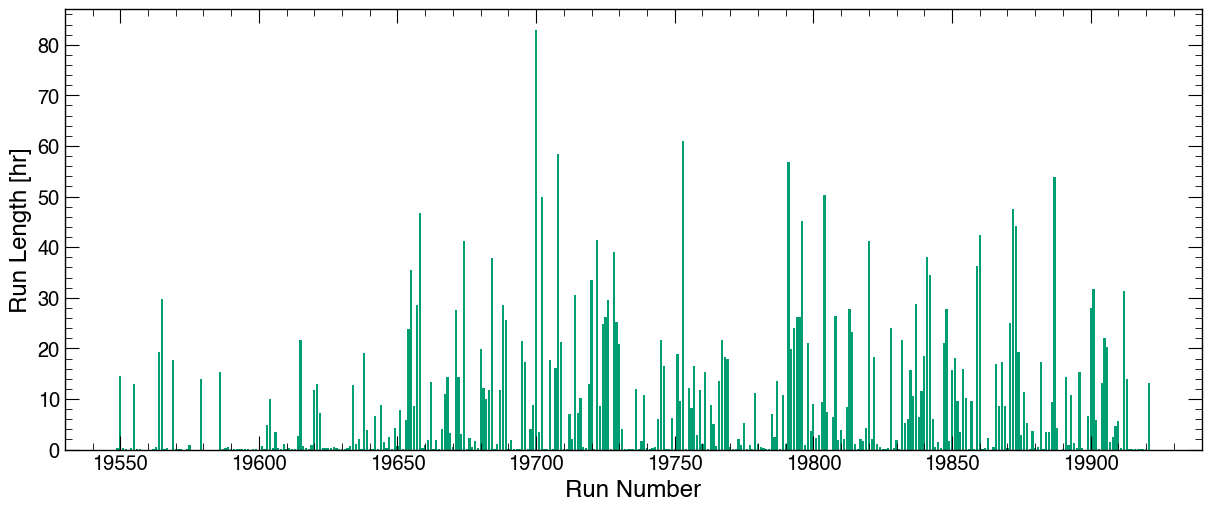

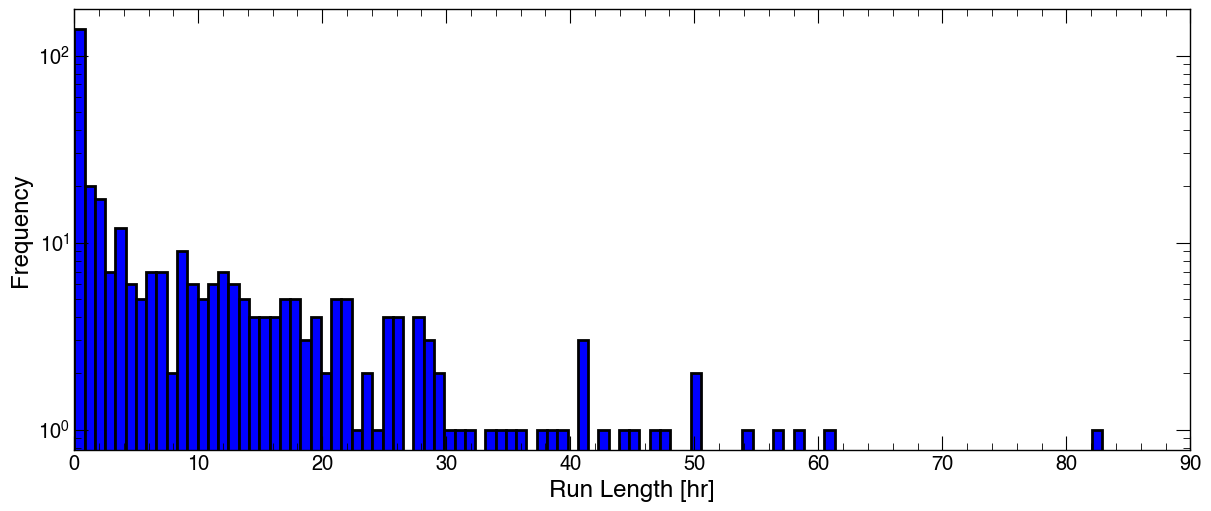

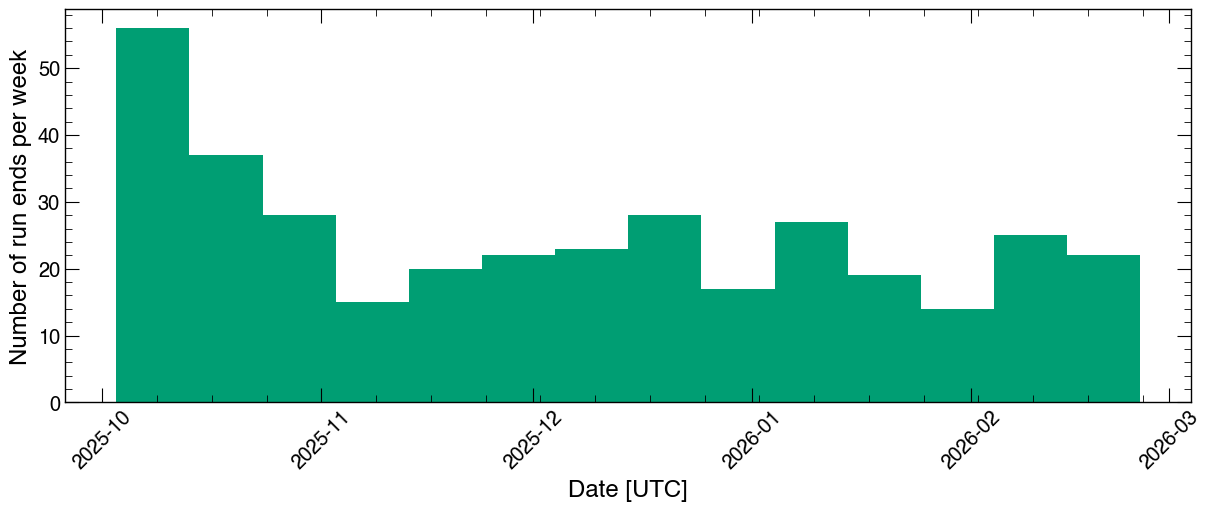

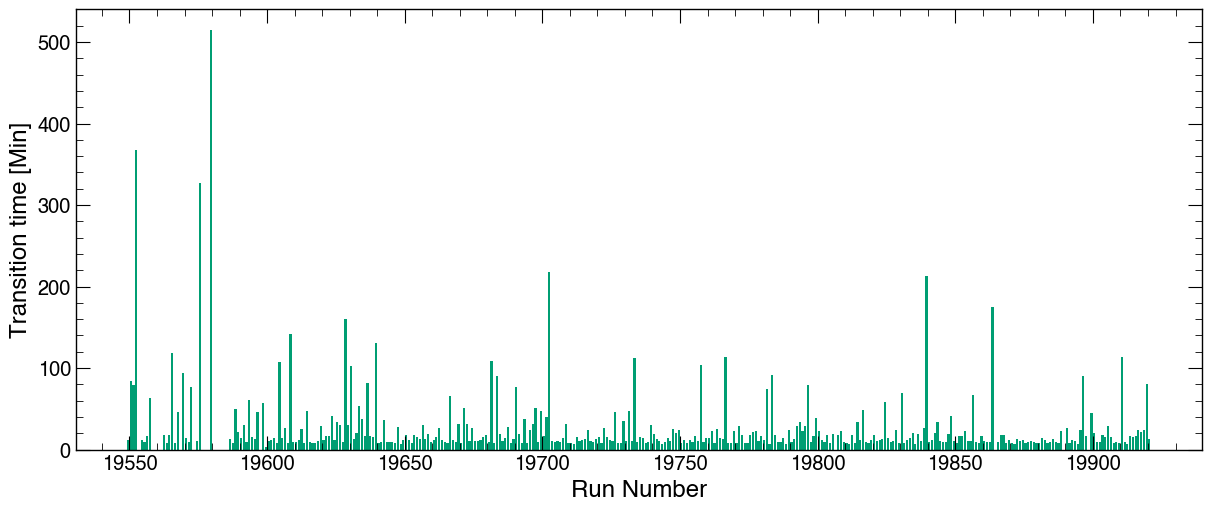

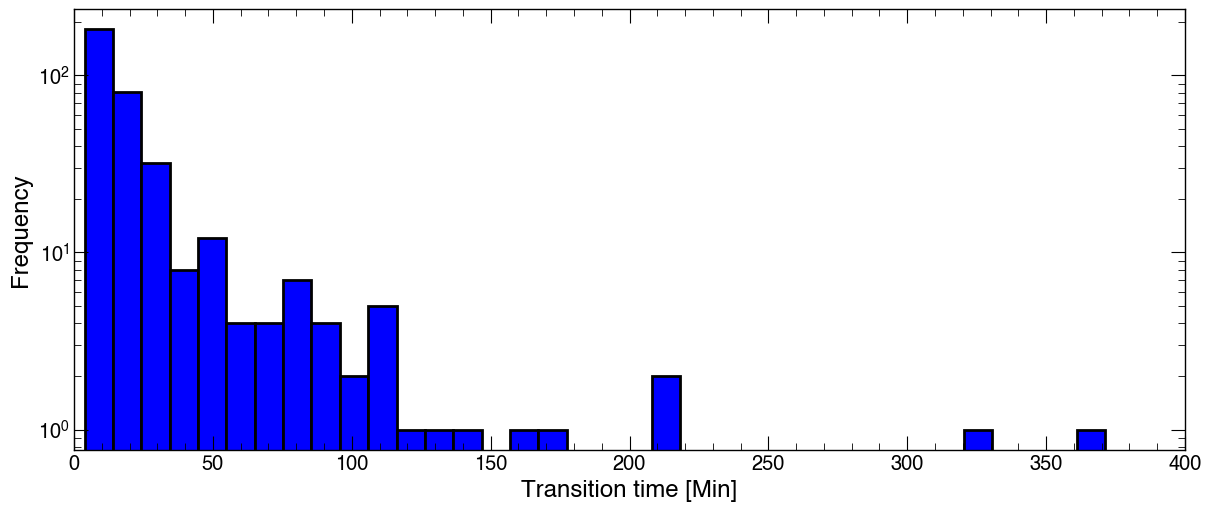

In [18]:
# Putting this here again so that this portion of the code can run without the internet
# Read the run start times from `starts.txt`
with open('starts.txt', 'r') as f:
    lines = f.readlines()
    starts = [datetime.strptime(line.strip(), '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc) for line in lines]

# Read the run end times from `ends.txt`
with open('ends.txt', 'r') as f:
    lines = f.readlines()
    ends = [datetime.strptime(line.strip(), '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc) if line != 'now\n' else datetime.now(timezone.utc) for line in lines]

runNumbers = []
# Read the run numbers from `runNums.txt`
with open('runNums.txt', 'r') as f:
    runNumbers = f.readlines()
#    runs = [lines for line in lines]

first_date = starts[0]
days_since_first = [(s - first_date).days for s in starts]
print(days_since_first)

run_indeces = []
run_lengths = []
run_number = []
transition_indeces = []
transition_time = []
transition_number = []
# go through and calculate the run lengths
for i in range(len(starts)):
    #print("at index", i, "the start time is", starts[i], "and the end time is", ends[i])
#    print("run length is ", ends[i]-starts[i], "in minutes its", ((ends[i]-starts[i]).total_seconds())/(60*60))
#    if(i!=len(starts)-1): print("transition took ", (starts[i+1]-ends[i]))
    if(i!=len(starts)-1):    
        run_indeces.append(i)
        run_number.append(float(runNumbers[i]))
        run_lengths.append(((ends[i]-starts[i]).total_seconds())/(60*60))
        if(i!=len(starts)-2):
            transition_indeces.append(i)
            transition_number.append(float(runNumbers[i])+0.5)
            transition_time.append((starts[i+1]-ends[i]).total_seconds()/(60))

# Figure creation
figure = plt.figure(figsize=(12, 5))
ax = figure.add_subplot()

print(len(run_lengths))

ax.bar(run_number, run_lengths, alpha=1, zorder=1, color='C0')
ax.set_xlabel('Run Number')
#plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='center')
ax.set_ylabel('Run Length [hr]')

# Histogram of frequency
figure = plt.figure(figsize=(12, 5))
ax2 = figure.add_subplot()
ax2.hist(run_lengths, bins=100, color='blue', edgecolor='black')
ax2.set_xlabel("Run Length [hr]")
ax2.set_ylabel("Frequency")
ax2.set_yscale('log')
ax2.set_xlim(0, 90)


# Histogram of the number of run ends for each day
figure = plt.figure(figsize=(12, 5))
ax3 = figure.add_subplot()
ax3.hist(ends, bins=14)
ax3.set_xlabel('Date [UTC]')
ax3.set_ylabel('Number of run ends per week')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='center')

# bar graph of transition time vs run number
figure = plt.figure(figsize=(12, 5))
ax = figure.add_subplot()
ax.bar(transition_number, transition_time, alpha=1, zorder=1, color='C0')
ax.set_xlabel('Run Number')
ax.set_ylabel('Transition time [Min]')

# Histogram of frequency
figure = plt.figure(figsize=(12, 5))
ax2 = figure.add_subplot()
ax2.hist(transition_time, bins=50, color='blue', edgecolor='black')
ax2.set_xlabel("Transition time [Min]")
ax2.set_ylabel("Frequency")
ax2.set_yscale('log')
ax2.set_xlim(0,400)
